In [5]:
"""
    Copyright (c) 2021 Olivier Leblanc

    Permission is hereby granted, free of charge, to any person obtaining
    a copy of this software and associated documentation files (the "Software"),
    to deal in the Software without restriction, including without limitation
    the rights to use, copy, modify, merge, publish, distribute, and to permit
    persons to whom the Software is furnished to do so.
    However, anyone intending to sublicense and/or sell copies of the Software
    will require the official permission of the author.
    ----------------------------------------------------------------------------

    Author : Olivier Leblanc
    Date : 05/06/2021

    Code description :
    __________________
    Analysis of the Fourier sampling depending on the core distribution.
"""
import matplotlib.pyplot as plt
import numpy as np
import sys, os
def updir(d, n):
  for _ in range(n):
    d = os.path.dirname(d)
  return d
sys.path.append(os.path.join(updir(os.getcwd(),1),'utils'))

from interferometric_lensless_imaging import *
from graphics import set_plot_params, subplot_axs, labels
from shepp_logan import phantom
set_plot_params() # Set the plot params

# Analysis of the sampling in Fourier domain
Define $\boldsymbol{S}_{\Omega}$ and $\boldsymbol{S}_{\Omega}^*$ : the restriction to $\Omega = \left\{ \boldsymbol{p}_i-\boldsymbol{p}_j,~i,j \in [Q] \right\}$

In [7]:
def LE_sampling (x, pos):
    """Applies sampling of object at difference 'q_i-q_j' between the cores position of the LE.
       y = S_Om_star(S_Om(x))

    Args:
        x (2D array)  : Object to be sampled.
        pos (2xJ array): [x,y] coordinates of the J cores.

    Returns:
        out (2D array): the sampled signal.

    """
    Om_x = np.subtract.outer(pos[0,:], pos[0,:]).astype(int)
    Om_y = np.subtract.outer(pos[1,:], pos[1,:]).astype(int)
    out = S_Om_star( S_Om(x, Om_x,Om_y), Om_x,Om_y, x.shape)
    return out

## Shows the sampling of the Shepp-Logan figure in Fourier

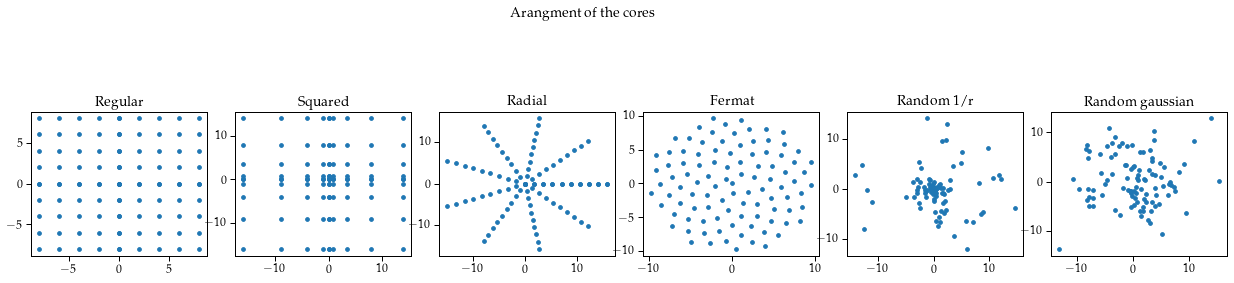

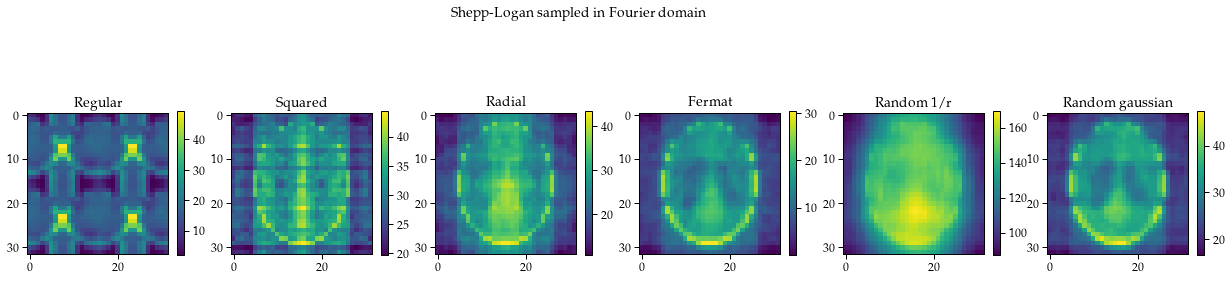

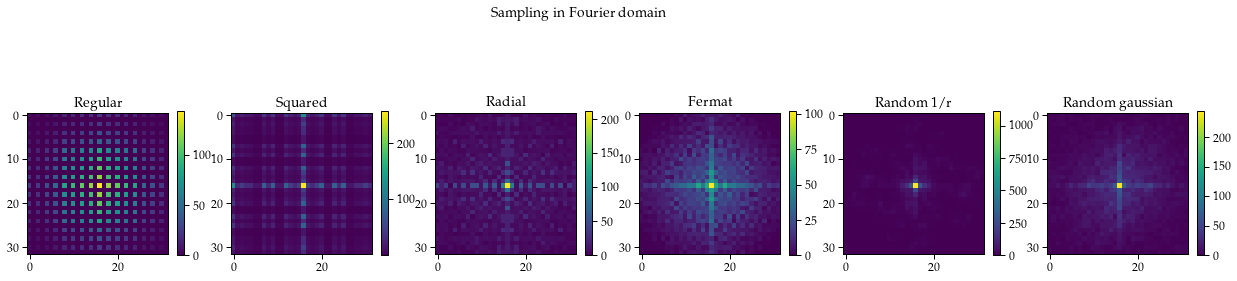

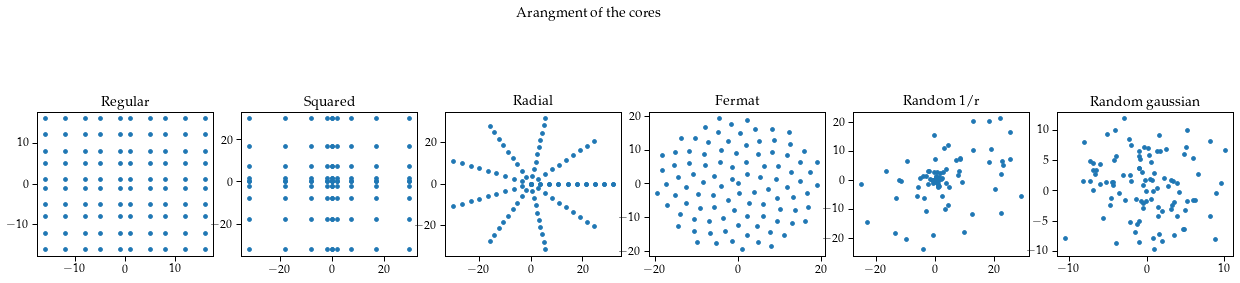

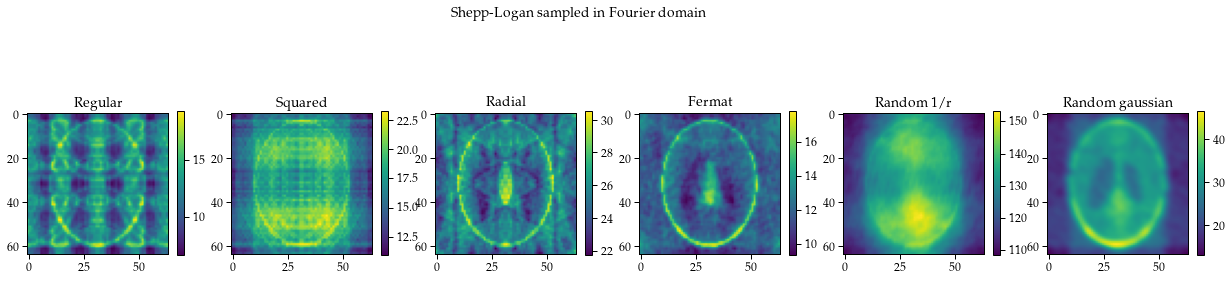

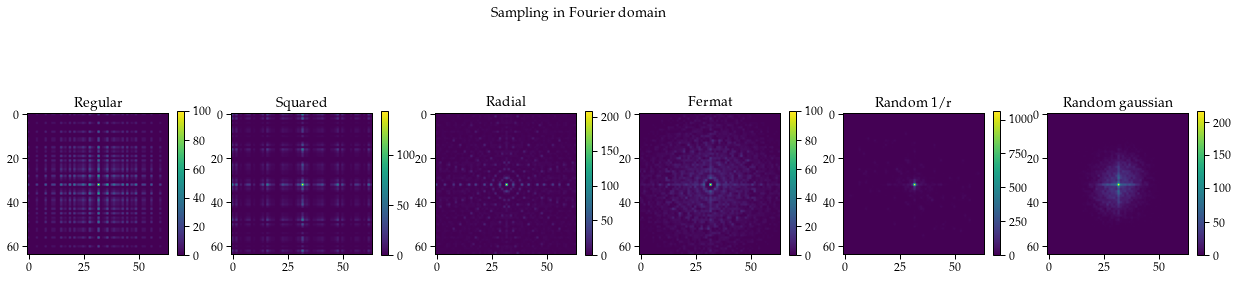

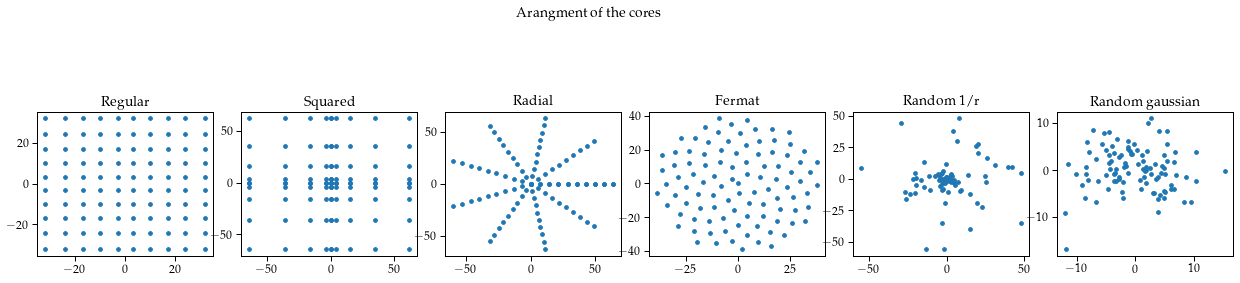

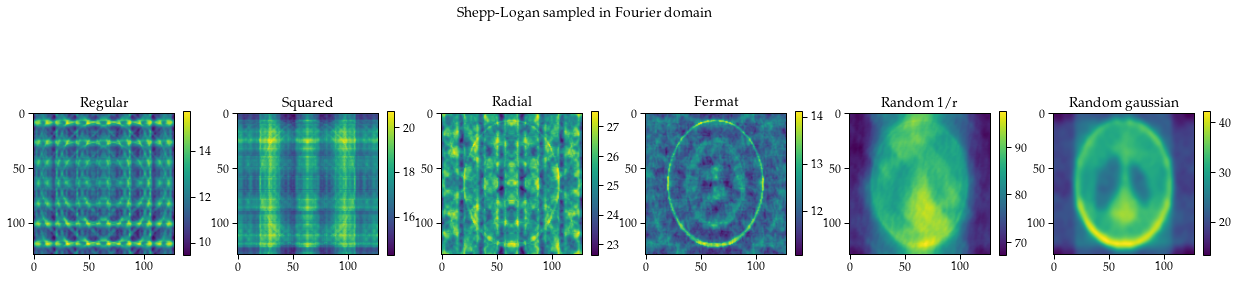

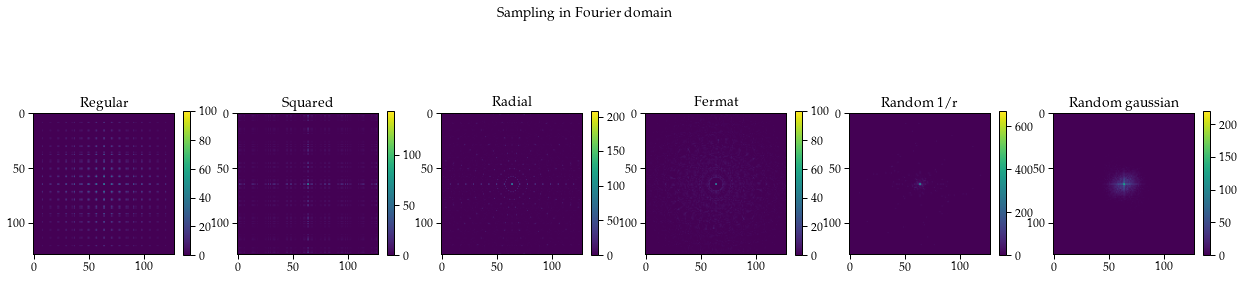

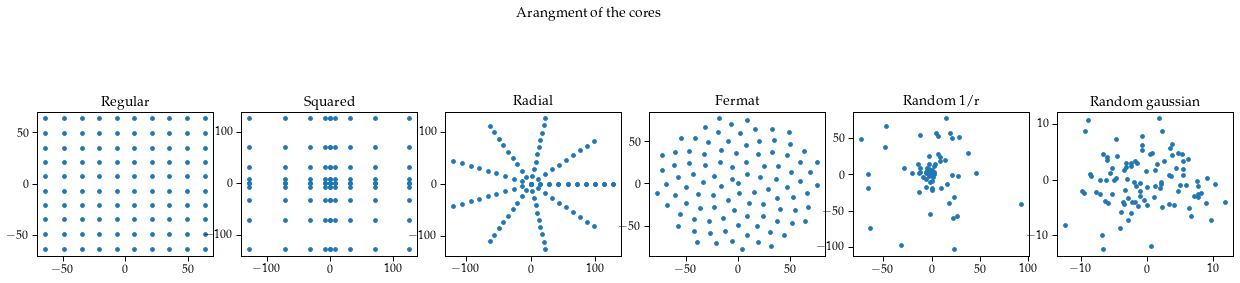

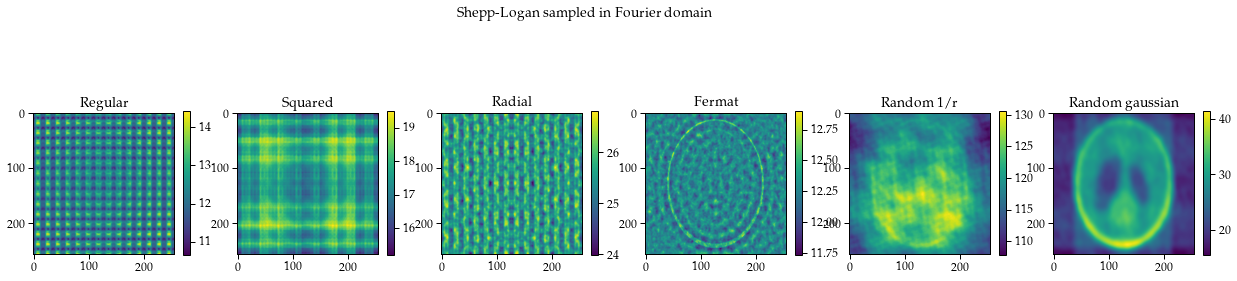

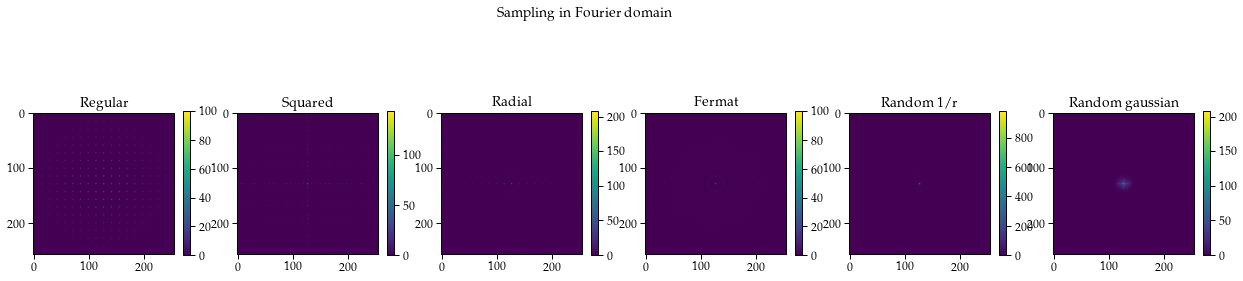

In [8]:
sizes = np.array([32,64,128,256])

for size in sizes :
    f_bar = phantom(size)
    f_bar_f = fft2(f_bar)
    H, W = f_bar.shape

    "Regular grid"
    indy = np.linspace(-H/4, H/4, 10).astype(int)
    indx = np.linspace(-W/4, W/4, 10).astype(int)
    xx, yy = np.meshgrid(indx,indy)
    pos_sources0 = np.array([xx.reshape(-1), yy.reshape(-1)])
    regular = LE_sampling(f_bar_f, pos_sources0)

    "Squared"
    N = 10
    x = (np.array([-np.linspace(0,H/2,int(N/2))**2, np.linspace(0,H/2-1,int(N/2))**2]))/(H/2) # spacing is squared
    xx, yy = np.meshgrid(x, x)
    pos_sources1 = np.array([xx.reshape(-1), yy.reshape(-1)])
    squared = LE_sampling(f_bar_f, pos_sources1)

    "Radial"
    N = 10
    rho = np.linspace(0,H/2,N)
    thetas = np.linspace(0,2*np.pi, 10)
    allrad, alltheta = np.meshgrid(rho, thetas)
    x = allrad*np.cos(alltheta)
    y = allrad*np.sin(alltheta)
    pos_sources2 = np.array([np.reshape(x,-1), np.reshape(y,-1)])
    radial = LE_sampling(f_bar_f, pos_sources2)

    "Fermat spiral"
    nCores = 100
    diam_endo = np.sqrt(2)*H/2
    pos_sources3 = LE_cores (diam_endo, nCores, sources_shape = 'fermat')
    fermat = LE_sampling(f_bar_f, pos_sources3)

    "Random 1/r"
    R = (size-1)/2
    candidates = np.linspace(0, R,100)
    probability_distribution = 1/(2*np.pi*np.log(R+1)*(candidates+1))
    probability_distribution /= np.sum(probability_distribution) #Normalization
    rand_r = np.random.choice(candidates, size=nCores, p=probability_distribution)
    rand_ang = np.random.uniform(0,2*np.pi, nCores)
    pos_sources4 = rand_r*np.array([np.cos(rand_ang), np.sin(rand_ang)])
    random1 = LE_sampling(f_bar_f, pos_sources4)

    "Random gaussian"
    sig = 5
    pos_sources5 = sig*np.random.randn(2, nCores)
    mx = (size-1)/2
    pos_sources5[0,pos_sources5[0,:]>mx] = mx
    pos_sources5[0,pos_sources5[0,:]<-mx] = -mx
    pos_sources5[1,pos_sources5[1,:]>mx] = mx
    pos_sources5[1,pos_sources5[1,:]<-mx] = -mx
    gaussian = LE_sampling(f_bar_f, pos_sources5)

    """ Plots """
    fig0 = plt.figure(figsize=(17,3))
    fig0.suptitle('Arangment of the cores', y=1.9, fontsize=14, x=0.5)
    axs = subplot_axs(fig0, 1,6)
    cores0 = axs[0].scatter(pos_sources0[0], pos_sources0[1], marker='o', label='Sources', s = 15)
    cores1 = axs[1].scatter(pos_sources1[0], pos_sources1[1], marker='o', label='Sources', s = 15)
    cores2 = axs[2].scatter(pos_sources2[0], pos_sources2[1], marker='o', label='Sources', s = 15)
    cores3 = axs[3].scatter(pos_sources3[0], pos_sources3[1], marker='o', label='Sources', s = 15)
    cores4 = axs[4].scatter(pos_sources4[0], pos_sources4[1], marker='o', label='Sources', s = 15)
    cores5 = axs[5].scatter(pos_sources5[0], pos_sources5[1], marker='o', label='Sources', s = 15)
    labels(axs[0], 'Regular')
    labels(axs[1], 'Squared')
    labels(axs[2], 'Radial')
    labels(axs[3], 'Fermat')
    labels(axs[4], 'Random 1/r')
    labels(axs[5], 'Random gaussian')
    plt.show()


    fig = plt.figure(figsize=(17,3))
    fig.suptitle('Shepp-Logan subsampled in Fourier domain', y=1.9, fontsize=14, x=0.5)
    axs = subplot_axs(fig,1,6)
    im0=axs[0].imshow(np.abs(ifft2(regular)), cmap='viridis')
    im1=axs[1].imshow(np.abs(ifft2(squared)), cmap='viridis')
    im2=axs[2].imshow(np.abs(ifft2(radial)), cmap='viridis')
    im3=axs[3].imshow(np.abs(ifft2(fermat)), cmap='viridis')
    im4=axs[4].imshow(np.abs(ifft2(random1)), cmap='viridis')
    im5=axs[5].imshow(np.abs(ifft2(gaussian)), cmap='viridis')
    labels(axs[0], 'Regular')
    labels(axs[1], 'Squared')
    labels(axs[2], 'Radial')
    labels(axs[3], 'Fermat')
    labels(axs[4], 'Random 1/r')
    labels(axs[5], 'Random gaussian')
    cb0 = fig.colorbar(im0, ax=axs[0])
    cb1 = fig.colorbar(im1, ax=axs[1])
    cb2 = fig.colorbar(im2, ax=axs[2])
    cb3 = fig.colorbar(im3, ax=axs[3])
    cb4 = fig.colorbar(im4, ax=axs[4])
    cb5 = fig.colorbar(im5, ax=axs[5])
    plt.show()


    f_bar2 = np.ones(f_bar.shape)
    regular2 = fftshift(LE_sampling(f_bar2, pos_sources0))
    squared2 = fftshift(LE_sampling(f_bar2, pos_sources1))
    radial2 = fftshift(LE_sampling(f_bar2, pos_sources2))
    fermat2 = fftshift(LE_sampling(f_bar2, pos_sources3))
    random2 = fftshift(LE_sampling(f_bar2, pos_sources4))
    gaussian2 = fftshift(LE_sampling(f_bar2, pos_sources5))

    fig = plt.figure(figsize=(17,3))
    fig.suptitle('Sampling in Fourier domain', y=1.9, fontsize=14, x=0.5)
    axs = subplot_axs(fig,1,6)
    im0=axs[0].imshow(np.abs(regular2), cmap='viridis')
    im1=axs[1].imshow(np.abs(squared2), cmap='viridis')
    im2=axs[2].imshow(np.abs(radial2), cmap='viridis')
    im3=axs[3].imshow(np.abs(fermat2), cmap='viridis')
    im4=axs[4].imshow(np.abs(random2), cmap='viridis')
    im5=axs[5].imshow(np.abs(gaussian2), cmap='viridis')
    labels(axs[0], 'Regular')
    labels(axs[1], 'Squared')
    labels(axs[2], 'Radial')
    labels(axs[3], 'Fermat')
    labels(axs[4], 'Random 1/r')
    labels(axs[5], 'Random gaussian')
    cb0 = fig.colorbar(im0, ax=axs[0])
    cb1 = fig.colorbar(im1, ax=axs[1])
    cb2 = fig.colorbar(im2, ax=axs[2])
    cb3 = fig.colorbar(im3, ax=axs[3])
    cb4 = fig.colorbar(im4, ax=axs[4])
    cb5 = fig.colorbar(im5, ax=axs[5])
    plt.show()